In [2]:
import os
import sys

import pandas as pd

module_path = os.path.abspath("..")
sys.path.append(module_path)

import finance_client as fc
from finance_client import graph
from finance_client import fprocess

In [3]:
data_folder = "L:/data/"
file_name_generator = lambda symbol: f"{data_folder}/yfinance/yfinance_{symbol}.T_D1.csv"

In [4]:
log_df = pd.read_csv(f"{data_folder}/trade/finance_client_trading_log.csv", parse_dates=["time"])
log_df.head()

,symbol,time,price,amount,position_type,order_type,logged_at
0,2914,2024-02-01,NaN,1,1,open,2024-02-01
1,7751,2024-02-01,NaN,1,1,open,2024-02-01
2,8795,2024-02-01,NaN,1,1,open,2024-02-01
3,7261,2024-02-01,NaN,1,1,open,2024-02-01
4,9202,2024-02-01,NaN,1,1,open,2024-02-01


2025-12-13 11:46:04,904 finance_client.wallet:39 __init__ [INFO]: MarketManager is initialized with budget:1000000, provider:csv


C:\Users\ksato\workspace\git\finance_client\src\finance_client\graph.py:513: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


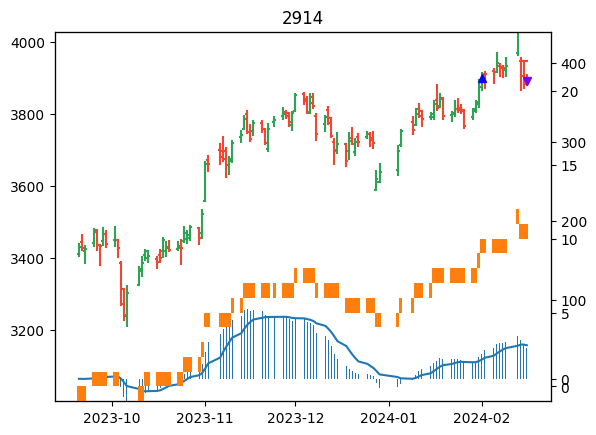

In [23]:
for symbol in log_df["symbol"]:
    render = graph.Rendere()
    symbol_df = log_df[log_df["symbol"] == symbol]
    start_date = symbol_df["time"].max()
    symbol_file = file_name_generator(symbol)
    macd_p = fprocess.MACDProcess(target_column="Close")
    renko_p = fprocess.RenkoProcess()
    client = fc.CSVClient(symbol_file, start_date=start_date, date_column="Datetime", idc_process=[macd_p, renko_p])
    ohlc_df = client.get_ohlc(symbols=[str(symbol)], length=100)
    positions = [0 for i in range(len(ohlc_df))]
    prices = positions.copy()
    time_index = 0
    for index, position_time in enumerate(symbol_df["time"]):
        while time_index < len(ohlc_df) and ohlc_df.index[time_index] < position_time:
            positions[time_index] = 0
            prices[time_index] = ohlc_df["Close"].iloc[time_index]
            time_index += 1
        if time_index < len(ohlc_df):
            if symbol_df["order_type"].iloc[index] == "open":
                positions[time_index] = int(symbol_df["position_type"].iloc[index])
            else:
                if symbol_df["position_type"].iloc[index] == 1:
                    position = -2
                else:
                    position = -1
                positions[time_index] = position
            prices[time_index] = ohlc_df["Close"].iloc[time_index]
            time_index += 1
    graph_index = render.register_ohlc_with_indicaters([symbol], ohlc_df, idc_processes=[macd_p, renko_p], title=f"{symbol}")
    if len(positions) == len(ohlc_df):
        render.add_trade_histories_to_ohlc(positions, prices, graph_index)
    else:
        print("invalid positions")
    render.plot()
    # input("Please enter any key to show next")
    render.close()
    break